<a href="https://colab.research.google.com/github/econ105/AI/blob/main/%E3%80%8CUpsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"



import os: This statement imports the os module, which provides a way to interact with the operating system. It is commonly used for tasks such as file and directory operations.

import time: This statement imports the time module, which provides various functions related to time, such as measuring time intervals or pausing the execution of a program.

from PIL import Image: This statement imports the Image module from the PIL (Python Imaging Library) package. PIL is a library for opening, manipulating, and saving many different image file formats.

import numpy as np: This statement imports the numpy module and assigns it the alias np. Numpy is a powerful numerical computing library in Python that provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently.

import tensorflow as tf: This statement imports the tensorflow module, which is a popular open-source machine learning framework. TensorFlow provides a variety of tools and libraries for building and training machine learning models.

import tensorflow_hub as hub: This statement imports the tensorflow_hub module and assigns it the alias hub. TensorFlow Hub is a library that provides a repository of pre-trained machine learning models, which can be easily integrated into TensorFlow-based projects.

import matplotlib.pyplot as plt: This statement imports the pyplot module from the matplotlib package and assigns it the alias plt. Matplotlib is a plotting library in Python widely used for creating visualizations and graphs.

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True": This line sets an environment variable called TFHUB_DOWNLOAD_PROGRESS to the value "True". The purpose of this specific variable is to enable download progress reporting when using TensorFlow Hub to download and cache models.



In [ ]:
!wget "https://media-hosting.imagekit.io//9c48334010354fb2/undefined%20-%20Imgur.jpg?Expires=1834961505&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=p1jKqg40z0W9rspH4xXSX7hNBHnJFgCRAV23-5t~PdIY7e8SNWRET2RXNFW5K5LvksmjttSEu4-0LdIUc87ghwkPKpwYIq1R8JQjdHd~jLWGlhyYy1hxTMuVS2RElisJkJd-DPq1aHoLh-pC6jFZJ2I4wwbGvt~q-uerKbQR9bccwEba6W65vt7UrpBO~ESRqFSkiERKutVHn9lOsmIaY1tUQpvGNYQMQ7gc98dznLPR9igobzSNOtc-S2Rf4zNva48JF9awHWdf-g9HB5I8BB9oMQYdsNs55gF2Zkw4NCPvshLXoLY2Aqt17mdvrwSFFrCbMeVfDW8EOOrlqVgRSw__" -O original.jpg

--2025-02-24 07:04:53--  https://media-hosting.imagekit.io//9c48334010354fb2/undefined%20-%20Imgur.jpg?Expires=1834961505&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=p1jKqg40z0W9rspH4xXSX7hNBHnJFgCRAV23-5t~PdIY7e8SNWRET2RXNFW5K5LvksmjttSEu4-0LdIUc87ghwkPKpwYIq1R8JQjdHd~jLWGlhyYy1hxTMuVS2RElisJkJd-DPq1aHoLh-pC6jFZJ2I4wwbGvt~q-uerKbQR9bccwEba6W65vt7UrpBO~ESRqFSkiERKutVHn9lOsmIaY1tUQpvGNYQMQ7gc98dznLPR9igobzSNOtc-S2Rf4zNva48JF9awHWdf-g9HB5I8BB9oMQYdsNs55gF2Zkw4NCPvshLXoLY2Aqt17mdvrwSFFrCbMeVfDW8EOOrlqVgRSw__
Resolving media-hosting.imagekit.io (media-hosting.imagekit.io)... 3.171.22.115, 3.171.22.129, 3.171.22.72, ...
Connecting to media-hosting.imagekit.io (media-hosting.imagekit.io)|3.171.22.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5811 (5.7K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>]   5.67K  --.-KB/s    in 0s      

2025-02-24 07:04:53 (1.77 GB/s) - ‘original.jpg’ saved [5811/5811]





!: In a Jupyter notebook, the exclamation mark ! is used to indicate that the following command is a shell command, rather than a Python code statement.

wget: wget is a command-line utility used for downloading files from the web. It is commonly used in Unix-like systems, including Linux.

"https://i.imgur.com/nZLOgy7.jpg": This is the URL of the image file that we want to download. In this case, the image is hosted on Imgur and the URL points to the image file.

-O original.jpg: This is an option used with the wget command to specify the output file name. In this case, the downloaded image file will be saved with the name original.jpg.
Note that this link can be ended in png or jpg, for me, I turn the jpg image to jpg via the imgur https://h0339637.imgur.com/all, you can use png and upsample your own photo.




In [ ]:
# Declaring Constants
IMAGE_PATH = "original.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)



    preprocess_image(image_path):
        This function takes an argument image_path, which is the path to an image file.
        It loads the image from the specified path using tf.io.read_file and then decodes the image using tf.image.decode_image. The resulting image tensor is assigned to the variable hr_image.
        If the image has four color channels (RGBA), the alpha channel is removed by slicing the tensor using hr_image[...,:-1].
        The variable hr_size is calculated by dividing the dimensions of hr_image by 4 and rounding down to the nearest multiple of 4. This is done to ensure that the dimensions of the image are divisible by 4, which is a requirement for further processing.
        The image is cropped to the calculated hr_size using tf.image.crop_to_bounding_box.
        The image tensor is cast to tf.float32 using tf.cast.
        Finally, the image tensor is expanded to have an additional dimension at the beginning using tf.expand_dims, and the resulting tensor is returned.

    save_image(image, filename):
        This function takes two arguments: image, which is a 3D image tensor with dimensions [height, width, channels], and filename, which is the name of the file to save.
        If the image argument is not an instance of PIL.Image.Image, it is clipped to the range of 0 to 255 using tf.clip_by_value, then cast to tf.uint8 and converted to a NumPy array using .numpy(). The resulting array is then used to create a PIL.Image.Image object.
        The PIL.Image.Image object is saved as a JPEG file with the specified filename using image.save.
        A confirmation message is printed to indicate that the image has been saved.

In summary, preprocess_image loads and preprocesses an image file, returning a preprocessed image tensor, while save_image saves an image tensor or a PIL Image object as a JPEG file.

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


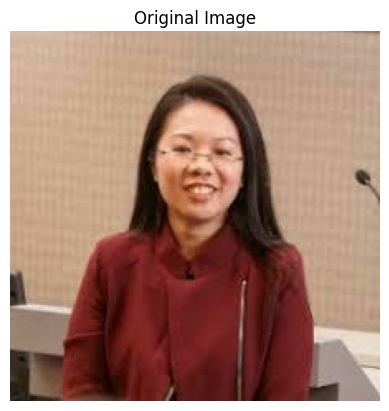

In [ ]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")



In [ ]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 8.971975


Saved as Super Resolution.jpg


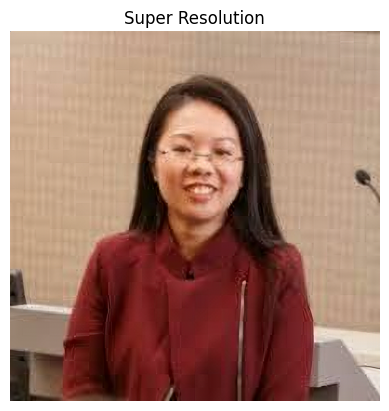

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [ ]:
#Evaluate model performance
!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

--2025-02-24 06:04:14--  https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64
Resolving lh4.googleusercontent.com (lh4.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to lh4.googleusercontent.com (lh4.googleusercontent.com)|108.177.121.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85087 (83K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  83.09K  --.-KB/s    in 0.001s  

2025-02-24 06:04:15 (73.2 MB/s) - ‘test.jpg’ saved [85087/85087]



In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

down images using bicubic downsampling. Let's break down the function:

    downscale_image(image):
        This function takes an argument image, which is a 3D or 4D tensor of a preprocessed image.
        The function first checks the shape of the image tensor to determine whether it is a 3D tensor or a 4D tensor. If it is a 3D tensor, the image size is extracted as [image.shape[1], image.shape[0]]. The shape is reversed because the dimensions of the image tensor are typically in the format [height, width, channels].
        If the image tensor has a dimension other than 3, a ValueError is raised, as the function can only work on a single image.
        The image tensor is then squeezed using tf.squeeze to remove any singleton dimensions and cast to tf.uint8 using tf.cast. Additionally, the values of the image tensor are clipped between 0 and 255 using tf.clip_by_value.
        The resulting tensor is converted to a NumPy array using .numpy() and then used to create a PIL.Image.Image object. The PIL.Image.Image object is resized to a quarter of the original image size using bicubic downsampling with the resize function from the PIL library.
        The resized image is converted back to a tensor using np.asarray and expanded to have an additional dimension at the beginning using tf.expand_dims.
        Finally, the tensor is cast to tf.float32 and returned as the resulting downsampled image tensor.

In summary, the downscale_image function takes an image tensor, scales it down using bicubic downsampling, and returns the downsampled image tensor.

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

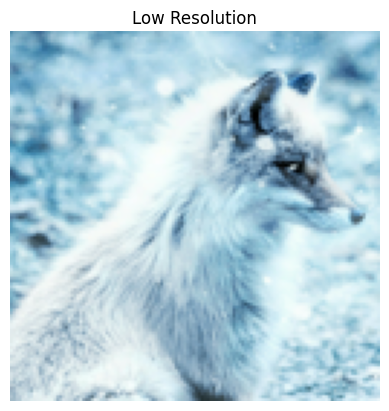

In [ ]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.914784


PSNR Achieved: 27.948008


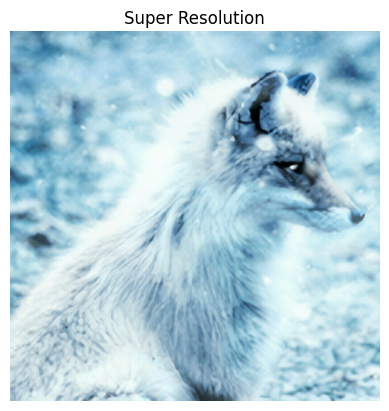

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 27.948008


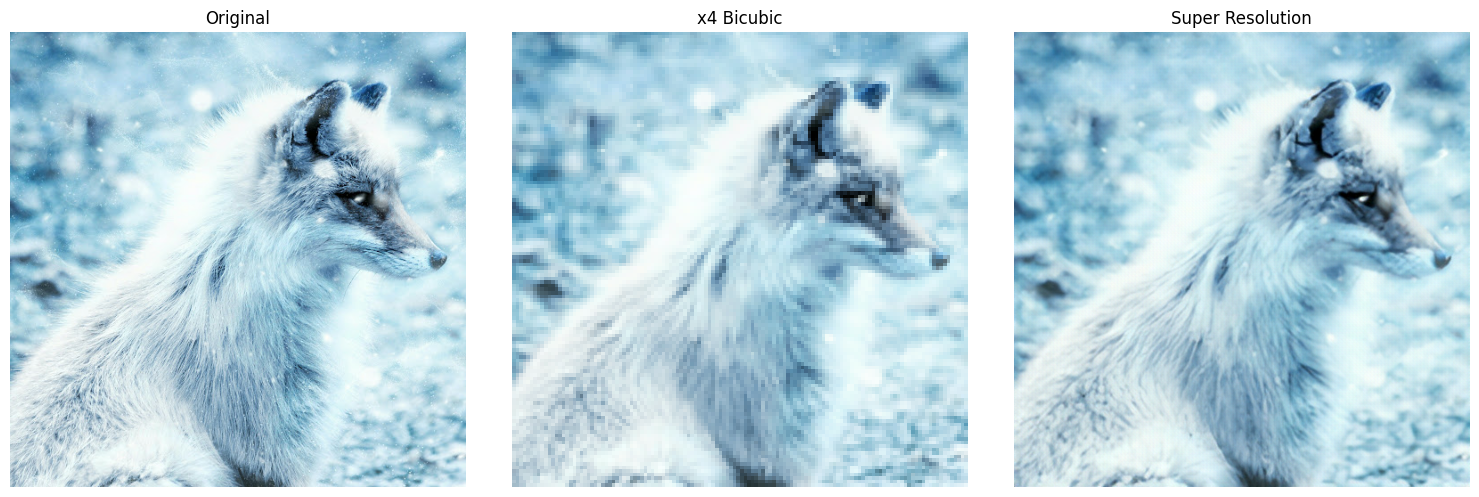

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)